In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from itertools import product
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

In [2]:
file_name = 'BELU_021101_211103.csv'
df = pd.read_csv(file_name)
print(f'shape: {df.shape}')
df.head(10)

shape: (1119, 9)


,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,BELU,D,20160701,0,400.0,400.0,395.0,396.0,3
1,BELU,D,20160704,0,403.0,416.0,403.0,407.0,11
2,BELU,D,20160705,0,401.0,401.0,400.0,400.0,5
3,BELU,D,20160706,0,400.0,400.0,390.0,395.0,185
4,BELU,D,20160707,0,397.0,397.0,397.0,397.0,1
5,BELU,D,20160708,0,399.0,399.0,399.0,399.0,1
6,BELU,D,20160711,0,398.0,415.0,396.0,398.0,599
7,BELU,D,20160712,0,400.0,408.0,394.0,394.0,33
8,BELU,D,20160713,0,403.0,403.0,394.0,402.0,4
9,BELU,D,20160714,0,397.0,397.0,396.0,396.0,3


In [3]:
df.drop(['<TICKER>', '<PER>', '<TIME>', '<OPEN>', '<LOW>', '<CLOSE>', '<VOL>'], axis=1, inplace=True)
df.drop([0, 1116, 1117, 1118], inplace=True)
print(df.shape)
df.head()

(1115, 2)


,<DATE>,<HIGH>
1,20160704,416.0
2,20160705,401.0
3,20160706,400.0
4,20160707,397.0
5,20160708,399.0


In [4]:
a = [max([df['<HIGH>'][i+j] for j in range(5)]) for i in range(1, 1040, 5)]
df_w=pd.DataFrame(pd.Series(a, name='High', index=df.index[:208]))

print(f'shape:{df_w.shape}')
df_w.head()

shape:(208, 1)


,High
1,416.0
2,415.0
3,395.0
4,393.0
5,540.0


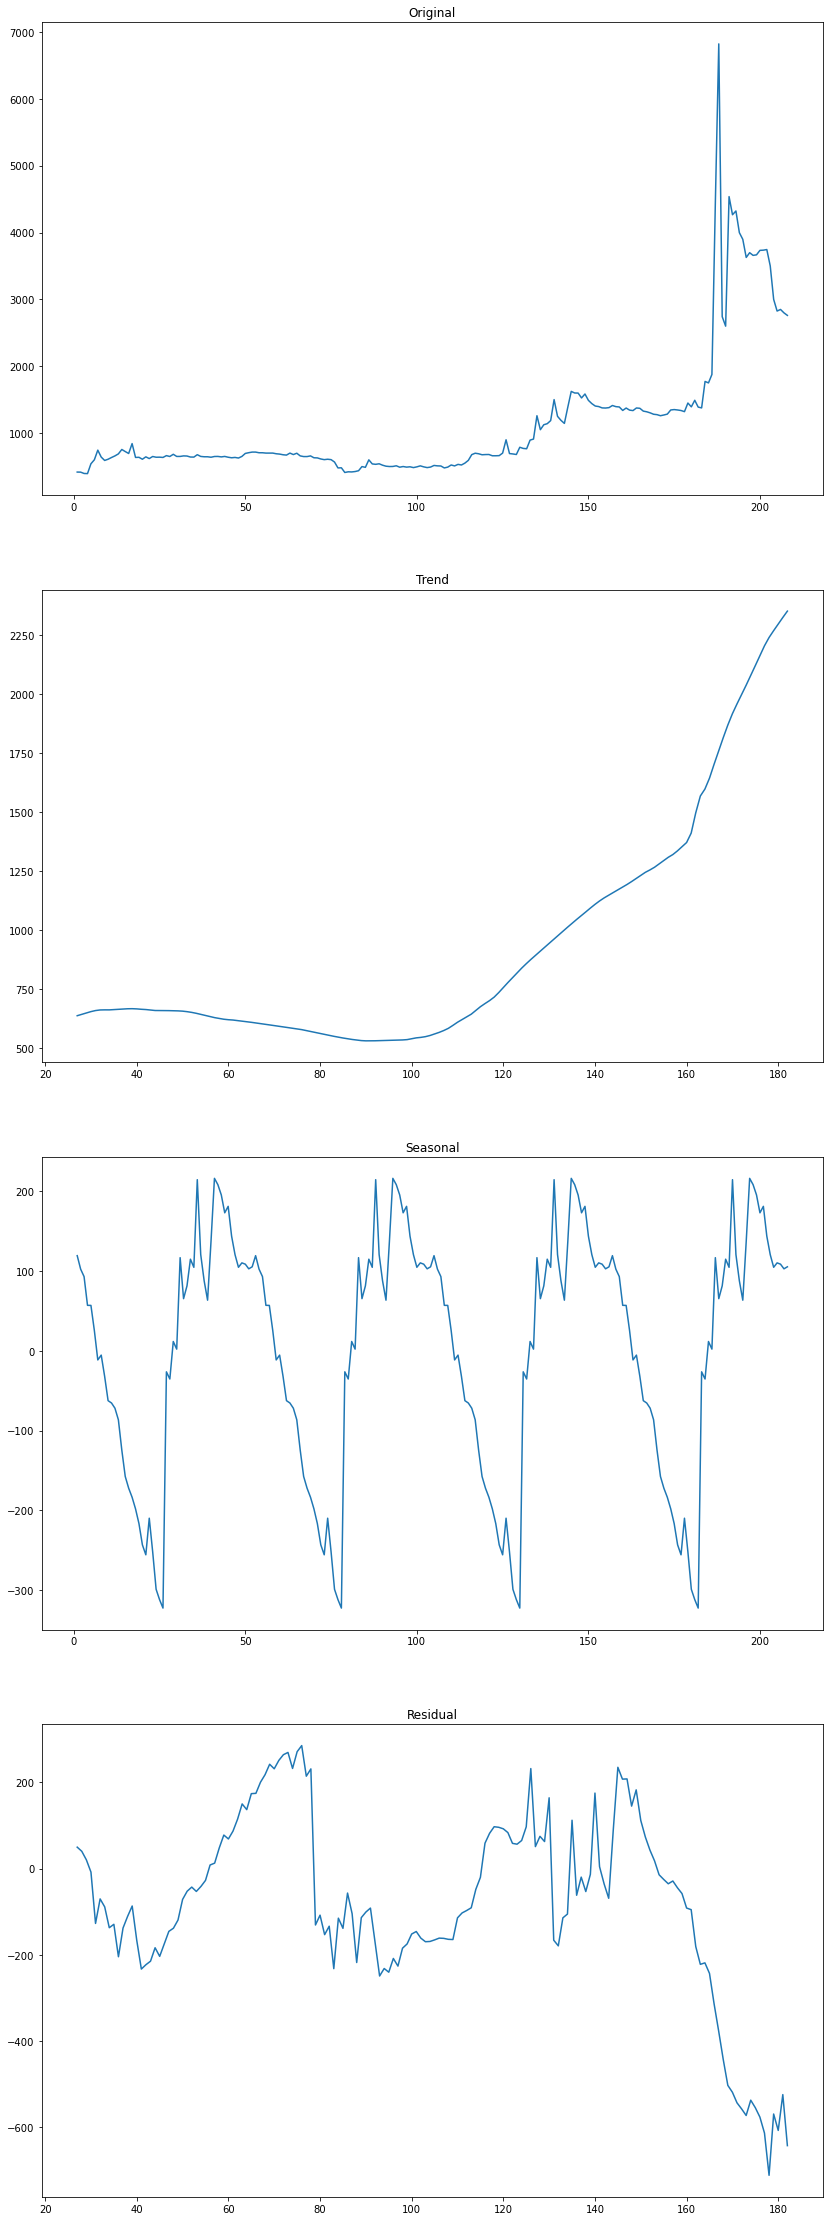

In [5]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(df_w[['High']], period=52)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

In [6]:
p_value = adfuller(df_w['High'])[1]
print(f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
f'{round(p_value, 4)} > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной!'
)

Полученный уровень значимости (p-value): 0.8253. 0.8253 > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной!


In [7]:
df_w['HighLog'] = np.log(df_w['High'])
df_w['HighLogDiff_1'] = df_w['HighLog'] - df_w['HighLog'].shift(1)
df_w.head()

,High,HighLog,HighLogDiff_1
1,416.0,6.030685,NaN
2,415.0,6.028279,-0.002407
3,395.0,5.978886,-0.049393
4,393.0,5.973810,-0.005076
5,540.0,6.291569,0.317760


Полученный уровень значимости (p-value): 0.0. 0.0 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


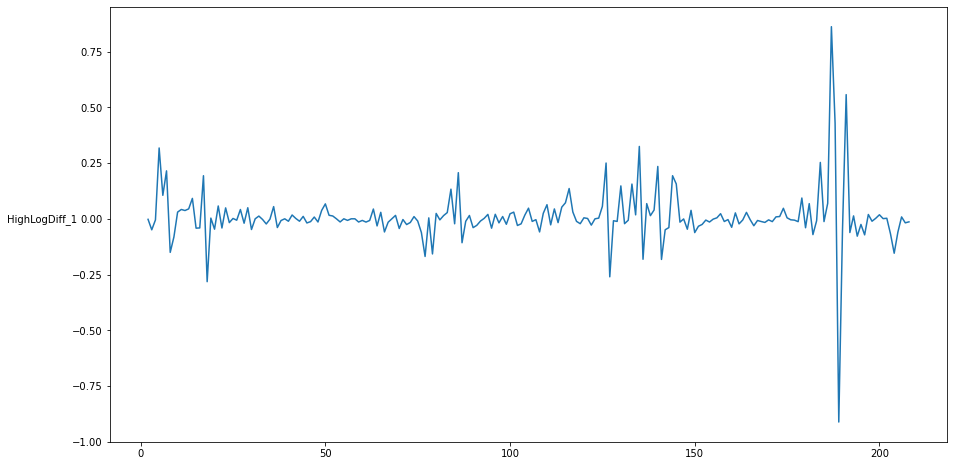

In [8]:
df_w['HighLogSDiff'] = df_w['HighLog'] - df_w['HighLog'].shift(12)
p_value = adfuller(df_w["HighLogDiff_1"][12:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
)

plt.figure(figsize=(15, 8))
plt.ylabel('HighLogDiff_1', rotation=0, labelpad=30)
df_w['HighLogDiff_1'].plot();

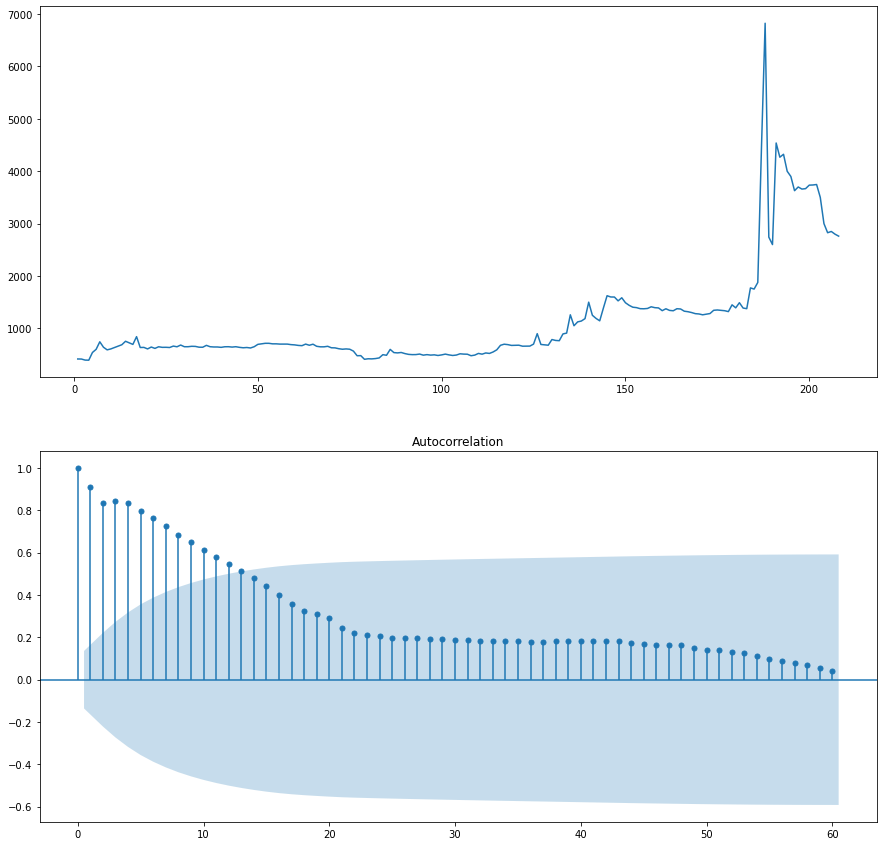

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
df_w['High'].plot(ax=ax[0])
plot_acf(df_w['High'], lags=60, ax=ax[1]);

In [10]:
d=1
D=1

qs = range(1, 5)
Qs = range(1, 3)

ps = range(1, 5)
Ps = range(3, 5)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [11]:
%%time

results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            df_w['HighLog'][:166], 
            order=(param[0], d, param[1]), 
            seasonal_order=(param[2], D, param[3], 52)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
  2%|█▎                                                                                 | 1/64 [00:41<43:23, 41.3

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 19%|██████████████▊                                                                | 12/64 [16:20<1:27:23, 100.84s/it]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 20%|████████████████▎                                                               | 13/64 [17:25<1:16:34, 90.10s/it]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base

 36%|████████████████████████████▊                                                   | 23/64 [33:47<1:03:08, 92.40s/it]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 38%|█████████████████████████████▋                                                 | 24/64 [36:18<1:13:21, 110.03s/it]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 53%|███████████████████████████████████████████                                      | 34/64 [53:10<51:22, 102.76s/it]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("M

 69%|██████████████████████████████████████████████████████▎                        | 44/64 [1:10:14<37:11, 111.59s/it]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 70%|███████████████████████████████████████████████████████▌                       | 45/64 [1:11:50<33:53, 107.03s/it]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base

 84%|██████████████████████████████████████████████████████████████████▋            | 54/64 [1:28:58<16:57, 101.70s/it]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 86%|███████████████████████████████████████████████████████████████████▉           | 55/64 [1:31:19<17:02, 113.56s/it]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base

100%|███████████████████████████████████████████████████████████████████████████████| 64/64 [1:50:14<00:00, 103.35s/it]

Wall time: 1h 50min 14s


In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
52  (4, 2, 3, 1) -190.237854
28  (2, 4, 3, 1) -190.177291
36  (3, 2, 3, 1) -189.936031
0   (1, 1, 3, 1) -189.674030
4   (1, 2, 3, 1) -188.229385


In [13]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              HighLog   No. Observations:                  166
Model:             SARIMAX(4, 1, 2)x(3, 1, [1], 52)   Log Likelihood                 106.119
Date:                              Tue, 28 Dec 2021   AIC                           -190.238
Time:                                      04:51:46   BIC                           -160.237
Sample:                                           0   HQIC                          -178.064
                                              - 166                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4053      0.177      2.285      0.022       0.058       0.753
ar.L2         -0.60

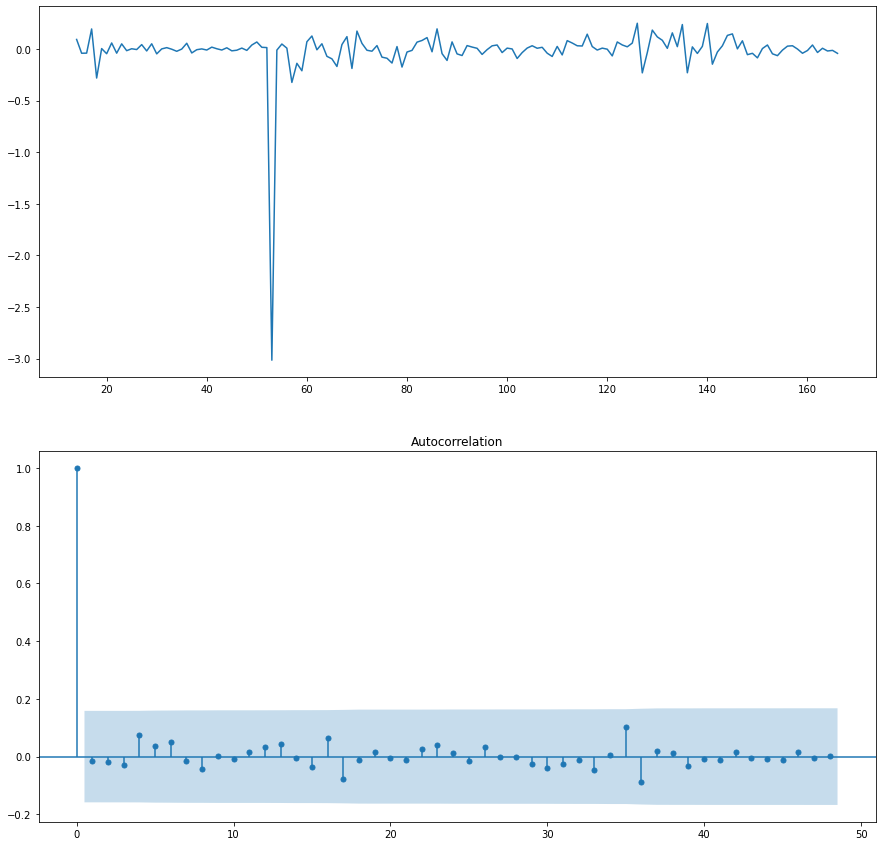

In [14]:
plt.figure(figsize=(15,15))

plt.subplot(211)
best_model.resid[13:].plot()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax);

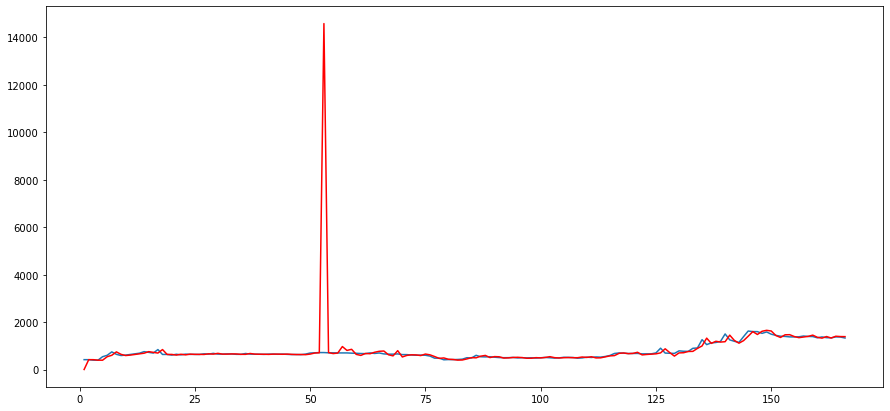

In [15]:
df_w['Model'] = np.exp(best_model.fittedvalues)

plt.figure(figsize=(15,7))

df_w['High'][:166].plot()
df_w['Model'].plot(c='r');

In [27]:
predict_len = 42
new_close_value = df_w[['High', 'Model']]

future_df = pd.DataFrame(columns=['High', 'Model'])
new_close_value = pd.concat([new_close_value, future_df])

print(new_close_value.shape)
new_close_value.tail()

(208, 2)


,High,Model
204,2999.0,NaN
205,2825.0,NaN
206,2849.0,NaN
207,2798.0,NaN
208,2760.0,NaN


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


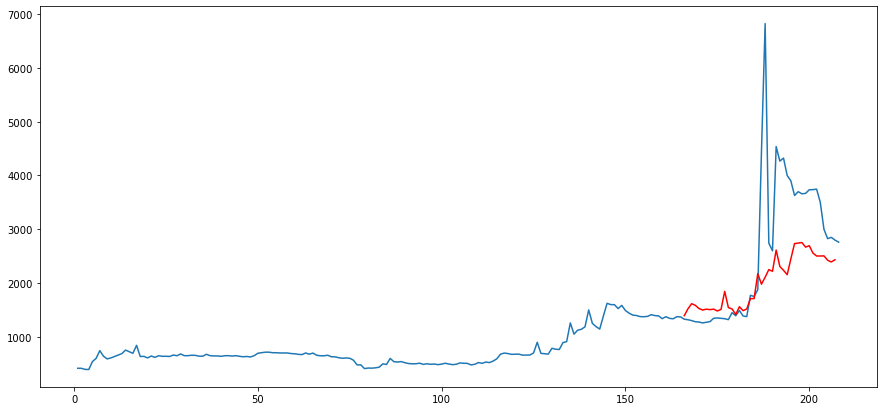

In [28]:
new_close_value['Model'] = np.exp(best_model.predict(start=166, end=166 + predict_len - 1))

plt.figure(figsize=(15,7))
new_close_value['High'].plot()
new_close_value['Model'].plot(c='r');

In [32]:
new_close_value.tail(44)

,High,Model
165,1370.0,NaN
166,1328.0,1393.970120
167,1318.0,1520.359310
168,1302.0,1616.190962
169,1281.0,1585.833192
170,1275.0,1525.991072
171,1259.0,1497.932511
172,1270.0,1514.660858
173,1283.0,1505.627510
174,1345.0,1515.393873


In [33]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(new_close_value['High'][166:207], new_close_value['Model'][166:207])

0.22889676528743086